In [1]:
!pip install pandas numpy spacy matplotlib seaborn scikit-learn vaderSentiment textblob


   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/626.3 kB ? eta -:--:--
   --------------------------------- ------ 524.3/626.3 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- 626.3/626.3 kB 728.4 kB/s eta 0:00:00


In [5]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 223.7 kB/s eta 0:00:55
     - ------------------------------------- 0.5/12.8 MB 223.7 kB/s eta 0:00:55
     - ------------------------------------- 0.5/12.8 MB 223.7 kB/s eta 0:00:55
     - ------------------------------------- 0.5/12.8 MB 223.7 kB/s eta 0:00:55
     - -------------------------

In [2]:
import pandas as pd

# Load datasets
gossip_fake = pd.read_csv("gossipcop_fake.csv")
gossip_real = pd.read_csv("gossipcop_real.csv")
politifact_fake = pd.read_csv("politifact_fake.csv")
politifact_real = pd.read_csv("politifact_real.csv")

# Add 'label' column (0: Fake, 1: Real)
gossip_fake['label'] = 0
gossip_real['label'] = 1
politifact_fake['label'] = 0
politifact_real['label'] = 1

# Combine all datasets
data = pd.concat([gossip_fake, gossip_real, politifact_fake, politifact_real], ignore_index=True)

# Check structure
print(data.head())


                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   
2   gossipcop-941805037  variety.com/2017/biz/news/tax-march-donald-tru...   
3  gossipcop-2547891536  www.dailymail.co.uk/femail/article-3499192/Do-...   
4  gossipcop-5476631226  variety.com/2018/film/news/list-2018-oscar-nom...   

                                               title  \
0  Did Miley Cyrus and Liam Hemsworth secretly ge...   
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...   
2  Celebrities Join Tax March in Protest of Donal...   
3  Cindy Crawford's daughter Kaia Gerber wears a ...   
4      Full List of 2018 Oscar Nominations – Variety   

                                           tweet_ids  label  
0  284329075902926848\t284332744559968256\t284335...      0  
1  992895508267130880\t992897935418503169\t992899...      0  
2  85335

In [8]:
print(data.columns)
# Display the required columns correctly
print(data[['id', 'news_url', 'popularity', 'cleaned_title', 'label']].head())


Index(['id', 'news_url', 'title', 'tweet_ids', 'label', 'popularity',
       'cleaned_title'],
      dtype='object')
                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   
2   gossipcop-941805037  variety.com/2017/biz/news/tax-march-donald-tru...   
3  gossipcop-2547891536  www.dailymail.co.uk/femail/article-3499192/Do-...   
4  gossipcop-5476631226  variety.com/2018/film/news/list-2018-oscar-nom...   

   popularity                                      cleaned_title  label  
0           1  did miley cyrus and liam hemsworth secretly ge...      0  
1           1  paris jackson  cara delevingne enjoy night out...      0  
2           1  celebrities join tax march in protest of donal...      0  
3           1  cindy crawfords daughter kaia gerber wears a w...      0  
4           1           full list of  oscar 

In [10]:
import re

# Popularity: Number of tweets
data['popularity'] = data['tweet_ids'].apply(lambda x: len(str(x).split(',')))

# Preprocess the 'title'
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text.lower().strip()

data['cleaned_title'] = data['title'].apply(clean_text)

# Check processed data
# Display the required columns correctly
print(data[['id', 'news_url', 'popularity', 'cleaned_title', 'label']].head())



                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   
2   gossipcop-941805037  variety.com/2017/biz/news/tax-march-donald-tru...   
3  gossipcop-2547891536  www.dailymail.co.uk/femail/article-3499192/Do-...   
4  gossipcop-5476631226  variety.com/2018/film/news/list-2018-oscar-nom...   

   popularity                                      cleaned_title  label  
0           1  did miley cyrus and liam hemsworth secretly ge...      0  
1           1  paris jackson  cara delevingne enjoy night out...      0  
2           1  celebrities join tax march in protest of donal...      0  
3           1  cindy crawfords daughter kaia gerber wears a w...      0  
4           1           full list of  oscar nominations  variety      0  


In [12]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Extract NER features
def extract_entities(text):
    doc = nlp(text)
    entities = {"ORG": 0, "PERSON": 0, "GPE": 0}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

data['entities'] = data['cleaned_title'].apply(extract_entities)
data['org_count'] = data['entities'].apply(lambda x: x['ORG'])
data['person_count'] = data['entities'].apply(lambda x: x['PERSON'])
data['gpe_count'] = data['entities'].apply(lambda x: x['GPE'])

# Check results
print(data[['cleaned_title', 'org_count', 'person_count', 'gpe_count']].head())


                                       cleaned_title  org_count  person_count  \
0  did miley cyrus and liam hemsworth secretly ge...          0             1   
1  paris jackson  cara delevingne enjoy night out...          0             0   
2  celebrities join tax march in protest of donal...          1             1   
3  cindy crawfords daughter kaia gerber wears a w...          1             2   
4           full list of  oscar nominations  variety          0             0   

   gpe_count  
0          0  
1          1  
2          0  
3          0  
4          0  


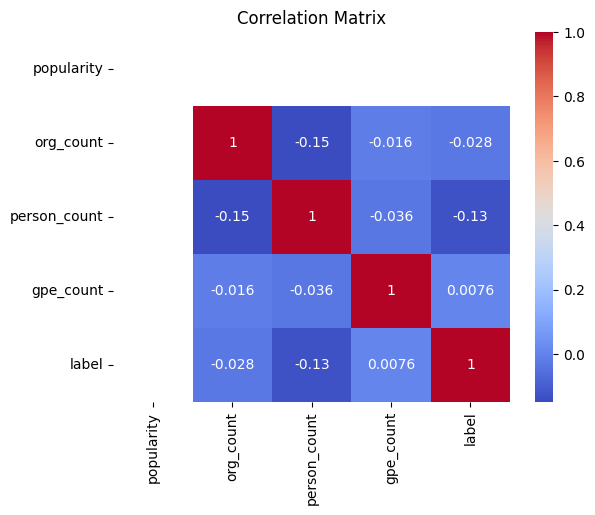

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select features for correlation
correlation_data = data[['popularity', 'org_count', 'person_count', 'gpe_count', 'label']]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Visualize correlation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


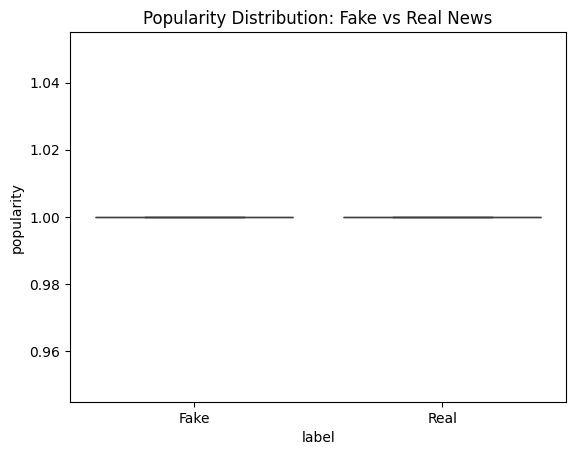

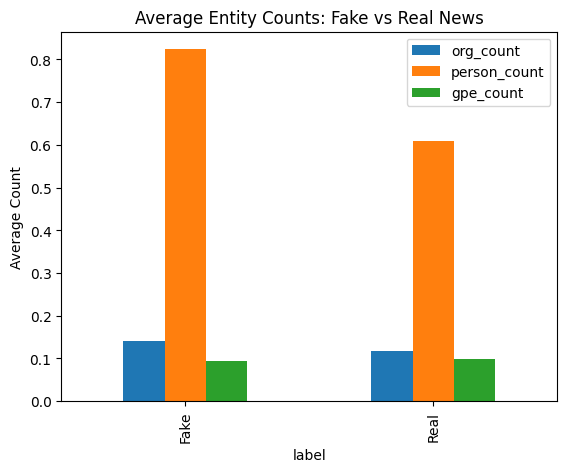

In [16]:
# Compare entity counts for fake vs real news
sns.boxplot(x='label', y='popularity', data=data)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Popularity Distribution: Fake vs Real News")
plt.show()

# Bar chart for average entity counts
entity_means = data.groupby('label')[['org_count', 'person_count', 'gpe_count']].mean()
entity_means.plot(kind='bar')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Average Entity Counts: Fake vs Real News")
plt.ylabel("Average Count")
plt.show()


In [18]:
# Save processed data
data.to_csv("processed_news_data.csv", index=False)
